In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data/diabetic_data.csv")

In [3]:
list(df.columns.values)

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

In [4]:
df.groupby('readmitted')['encounter_id'].nunique()

readmitted
<30    11357
>30    35545
NO     54864
Name: encounter_id, dtype: int64

In [5]:
# data cleaning

# pt 1: demographic vars
df.loc[df.weight == '?', 'weight'] = np.NaN

df.loc[df.race == 'Caucasian', 'race'] = 'Cau'
df.loc[df.race == 'AfricanAmerican', 'race'] = 'Aa'
df.loc[df.race == '?', 'race'] = np.NaN

df.loc[df.gender == 'Male', 'gender'] = 'M'
df.loc[df.gender == 'Female', 'gender'] = 'F'

# pt 2: medications
medlist = list(df.columns.values)[24:47]
for m in medlist:
    df.loc[df[m] != 'No', m] = 1 
    df.loc[df[m] == 'No', m] = 0
    
df.loc[df.change == 'No', 'change'] = 0
df.loc[df.change == 'Ch', 'change'] = 1
df.loc[df.diabetesMed == 'No', 'diabetesMed'] = 0
df.loc[df.diabetesMed == 'Yes', 'diabetesMed'] = 1

# create new binary response var
df['readmittedBool'] = df['readmitted']
df.loc[df.readmittedBool != 'NO', 'readmittedBool'] = 1
df.loc[df.readmittedBool == 'NO', 'readmittedBool'] = 0

df.loc[df.max_glu_serum == 'None', 'max_glu_serum'] = 0
df.loc[df.max_glu_serum == 'Norm', 'max_glu_serum'] = 1
df.loc[df.max_glu_serum == '>200', 'max_glu_serum'] = 200
df.loc[df.max_glu_serum == '>300', 'max_glu_serum'] = 300
df.loc[df.A1Cresult == 'None', 'A1Cresult'] = 0
df.loc[df.A1Cresult == 'Norm', 'A1Cresult'] = 1
df.loc[df.A1Cresult == '>7', 'A1Cresult'] = 7
df.loc[df.A1Cresult == '>8', 'A1Cresult'] = 8

df.loc[df.payer_code == '?', 'payer_code'] = np.NaN
df.loc[df.medical_specialty == '?', 'medical_specialty'] = np.NaN

# drop all columns that have same value 
#df.drop(['examide'], axis = 1, inplace = True)
#df.drop(['citoglipton'], axis = 1, inplace = True)

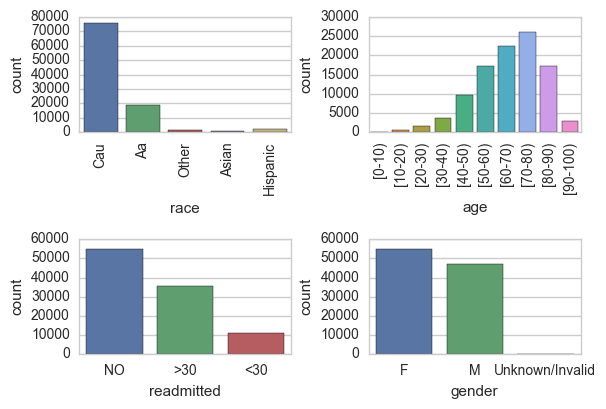

In [6]:
sns.set(style="whitegrid")
plt.subplot(2,2,1)
ax = sns.countplot(x="race", data=df)
plt.xlabel('race')
plt.xticks(rotation=90)
plt.subplot(2,2,2)
ax = sns.countplot(x="age", data=df)
plt.xticks(rotation=90)
plt.subplot(2,2,3)
ax = sns.countplot(x="readmitted", data=df)
plt.subplot(2,2,4)
ax = sns.countplot(x="gender", data=df)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [57]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,0:49]
X.drop(['encounter_id'], axis = 1, inplace = True)
X.drop(['patient_nbr'], axis = 1, inplace = True)
X.drop(['weight'], axis = 1, inplace = True)
X.drop(['admission_type_id'], axis = 1, inplace = True)
X.drop(['discharge_disposition_id'], axis = 1, inplace = True)
X.drop(['admission_source_id'], axis = 1, inplace = True)
X.drop(['medical_specialty'], axis = 1, inplace = True)
X.drop(['payer_code'], axis = 1, inplace = True)
y = np.asarray(df['readmittedBool'], dtype="|S6")

In [58]:
pd.get_dummies(X, prefix=['age'], columns=['age'])
X.drop(['age'], axis = 1, inplace = True)
pd.get_dummies(X, prefix=['gender'], columns=['gender'])
X.drop(['gender'], axis = 1, inplace = True)
pd.get_dummies(X, prefix=['race'], columns=['race'])
X.drop(['race'], axis = 1, inplace = True)

X.drop(['diag_1'], axis = 1, inplace = True)
X.drop(['diag_2'], axis = 1, inplace = True)
X.drop(['diag_3'], axis = 1, inplace = True)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [64]:
from sklearn.ensemble import RandomForestClassifier

test_error = []
training_error = []

depth = list(range(1,60))

for i in depth:
    clf = RandomForestClassifier(max_depth=i, random_state=42)
    clf.fit(X_train, y_train)
    training_error.append(1-clf.score(X_train, y_train))
    test_error.append(1-clf.score(X_test, y_test))

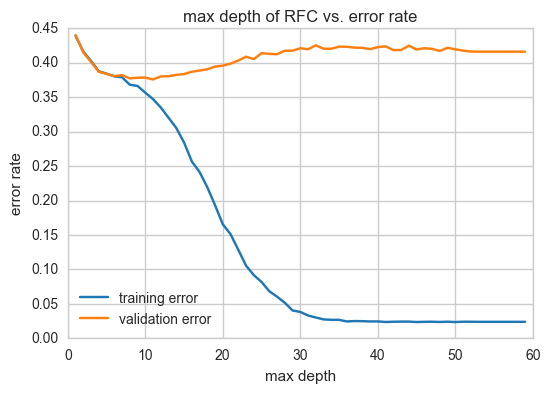

In [67]:
plt.plot(depth, training_error, color='#1f77b4', label="training error")
plt.plot(depth, test_error, color='#ff7f0e', label="validation error")
plt.xlabel('max depth')
plt.ylabel('error rate')
plt.title('max depth of RFC vs. error rate')
plt.legend(loc="best")
plt.show()

In [72]:
clf = RandomForestClassifier(max_depth=11, random_state=42)
clf.fit(X_train, y_train)
print('Training accuracy', clf.score(X_train, y_train))
print('Test accuracy', clf.score(X_test, y_test))

Training accuracy 0.652758018861
Test accuracy 0.624184855433


In [77]:
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(max_depth=11, random_state=42)
score = cross_val_score(clf, X, y, cv=10)
score.mean()

0.61673864486517316

Random Forest score after formatting data but before feature selection/feature engineering is 62.4%. 